In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import re

In [3]:
proj_path = '/content/drive/MyDrive/cs539_project/'
test_path = 'lfw-deepfunneled-test/'

In [4]:
# run once to create test directory if not already created
if test_path[:-1] not in os.listdir(proj_path):
  os.mkdir(proj_path + test_path)

  for name in os.listdir(proj_path + 'lfw-deepfunneled'):
    if name != '.DS_Store':
      os.mkdir(os.path.join(proj_path, test_path, name))

  with open(proj_path + 'peopleDevTest.txt', 'r') as f:
    lines = f.readlines()

  test_size = int(lines[0].strip())
  print(test_size)

  for sample in lines[1:]:
    temp = re.sub(r'\s',' ', sample).split(' ')
    name = temp[0]
    num = temp[1].zfill(4)
    # if name not in os.listdir(os.path.join(proj_path, test_path)):
    #   os.mkdir(os.path.join(proj_path, test_path, name))
    init_path = os.path.join(proj_path,'lfw-deepfunneled',name)
    img_name = name+'_'+num+'.jpg'
    if img_name in os.listdir(init_path):
      new_path = os.path.join(proj_path, test_path, name, img_name)
      os.rename(os.path.join(init_path, img_name), new_path)

# Preprocessing Data

(250, 250, 3)


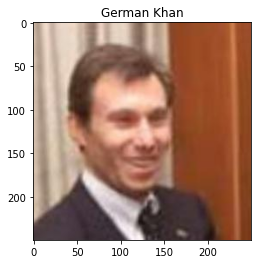

In [5]:
# Look at arbitrary images in the training set
for dirName, subdirList, fileList in os.walk(proj_path + 'lfw-deepfunneled/German_Khan'):
    for f in fileList:
        img = cv2.imread(os.path.join(dirName, f))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        print(img.shape)
        plt.imshow(img)
        plt.title(' '.join(dirName.split('/')[-1].split('_')))

In [6]:
# use haar cascade to detect faces in the images
def crop_face(img):
  clf = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  
  gray = np.array(gray, dtype='uint8')
  faces = clf.detectMultiScale(gray, 1.3, 3)
  
  cropped_img = None
  for (x, y, w, h) in faces:
    cropped_img = img[y:y+h,x:x+w]

  # use the center of the image if failed to detect faces
  if cropped_img is None:
    cropped_img = cv2.resize(img[61:189,61:189], (160,160))
  cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
  cropped_img = cv2.resize(cropped_img, (160,160))

  return (cropped_img - cropped_img.mean()) / cropped_img.std()

In [7]:
# generators for training and validation set
datagen = ImageDataGenerator(preprocessing_function=crop_face, validation_split=0.2)
train_gen = datagen.flow_from_directory(proj_path + 'lfw-deepfunneled', subset='training', target_size=(160, 160), color_mode='rgb')
val_gen = datagen.flow_from_directory(proj_path + 'lfw-deepfunneled', subset='validation', target_size=(160, 160), color_mode='rgb')

# generator for testing set
datagen = ImageDataGenerator(preprocessing_function=crop_face)
test_gen = datagen.flow_from_directory(proj_path + test_path, target_size=(160, 160), color_mode='rgb')

Found 10495 images belonging to 5749 classes.
Found 1027 images belonging to 5749 classes.
Found 1711 images belonging to 5749 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

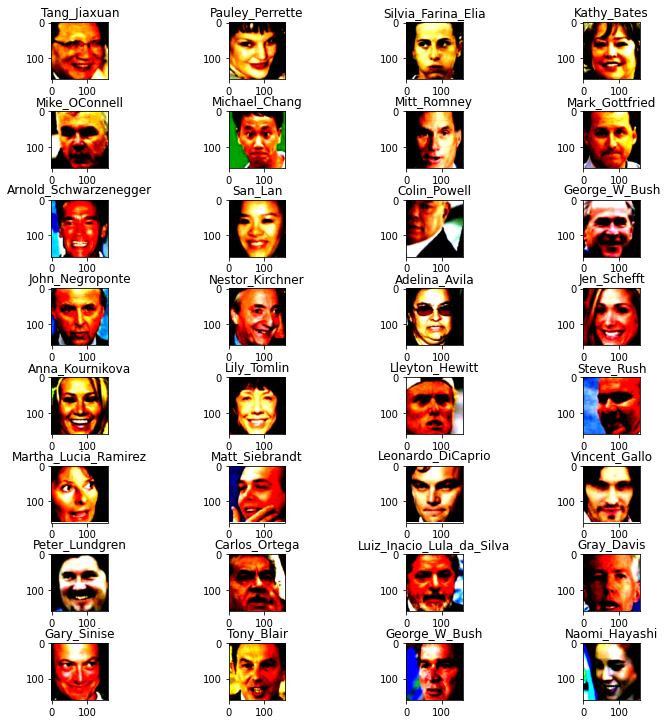

In [8]:
# Display images in a single batch
x_batch, y_batch = train_gen.next()
fig, ax = plt.subplots(8,4, figsize=(10,10))
fig.tight_layout()
for i in range(len(x_batch)):
    image = cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB)
    label = list(train_gen.class_indices.keys())[np.argmax(y_batch[i])]
    ax[i//4, i%4].imshow(image)
    ax[i//4, i%4].title.set_text(label)

In [9]:
# one-hot encoded label
y_batch[0].shape

(5749,)



# Embeddings

In [10]:
net = load_model(proj_path + 'facenet_keras.h5')
print(net.input_shape)
print(net.output_shape)

(None, 160, 160, 3)
(None, 128)


In [ ]:
net.summary()
#net.fit_generator(train_gen, steps_per_epoch=16, epochs=10, validation_data=validation_gen, validation_steps=8)

In [12]:
def triplet_loss(y_true, y_pred, alpha = 0.3):    
  anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]    
  pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)), axis=-1)
  neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
  basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
  loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
  return loss

In [13]:
net.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

In [14]:
img1 = cv2.imread(proj_path + "lfw-deepfunneled/Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg")
img2 = cv2.imread(proj_path + "lfw-deepfunneled/Abdoulaye_Wade/Abdoulaye_Wade_0004.jpg")

In [15]:
em1 = net.predict(np.expand_dims(crop_face(img1), axis=0))
em2 = net.predict(np.expand_dims(crop_face(img2), axis=0))

In [16]:
from scipy.spatial import distance
distance.euclidean(em1, em2)

10.508268356323242

In [20]:
# embeddings
X_train = net.predict(train_gen)
X_val = net.predict(val_gen)
X_test = net.predict(test_gen)

In [47]:
y_train = np.zeros((train_gen.samples,train_gen.num_classes))
for i in range(len(train_gen)):
  y_train[i*32:min((i+1)*32, train_gen.samples)] = train_gen[i][1]

In [48]:
y_val = np.zeros((val_gen.samples,val_gen.num_classes))
for i in range(len(val_gen)):
  y_val[i*32:min((i+1)*32, val_gen.samples)] = val_gen[i][1]

In [52]:
y_test = np.zeros((test_gen.samples,test_gen.num_classes))
for i in range(len(test_gen)):
  y_test[i*32:min((i+1)*32, test_gen.samples)] = test_gen[i][1]

In [53]:
def get_label(idx):
  return list(train_gen.class_indices.keys())[idx]

# Classification